# 감정 인식 데이터

## 패키지 로드 및 디렉토리 설정

In [14]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd drive/MyDrive/data/dataset

Mounted at /content/drive
/content/drive/MyDrive/data/dataset


In [22]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 7 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,542 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [15]:
from keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics, callbacks
from keras.callbacks import ModelCheckpoint
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import cv2
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd

In [16]:
import matplotlib.font_manager as fm
plt.rc('font', family='NanumGothic')

for fontInfo in fm.fontManager.ttflist:
    if 'Nanum' in fontInfo.name:
        print(fontInfo.name+" = "+fontInfo.fname)

NanumGothic = /usr/share/fonts/truetype/nanum/NanumGothic.ttf
NanumSquare = /usr/share/fonts/truetype/nanum/NanumSquareB.ttf
NanumMyeongjo = /usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf
NanumBarunGothic = /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
NanumGothic = /usr/share/fonts/truetype/nanum/NanumGothicBold.ttf
NanumSquare = /usr/share/fonts/truetype/nanum/NanumSquareR.ttf
NanumMyeongjo = /usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf
NanumBarunGothic = /usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf
NanumSquareRound = /usr/share/fonts/truetype/nanum/NanumSquareRoundR.ttf
NanumSquareRound = /usr/share/fonts/truetype/nanum/NanumSquareRoundB.ttf


## 데이터 로드 및 분할

In [18]:
categories = os.listdir()[:-6]
num_labels = len(categories)
categories

['슬픔', '중립', '기쁨', '당황', '분노', '불안', '상처']

In [19]:
image_w = 100
image_h = 100
  
X = []
Y = []
  
for idex, categorie in enumerate(categories):
    label = idex
    image_dir = categorie + '/'
  
    for top, dir, f in os.walk(image_dir):
        for filename in f:
            img = cv2.imread(image_dir+filename) # cv2.IMREAD_GRAYSCALE : 흑백 처리
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB, dst = img) # RGB 변환
            img = cv2.resize(img, None, fx=image_w/img.shape[1], fy=image_h/img.shape[0])
            X.append(img/255)
            Y.append(label)
 
X = np.array(X)
Y = np.array(Y)
 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 42)

In [20]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(1890, 100, 100, 3) (210, 100, 100, 3) (1890,) (210,)


In [38]:
train_input, val_input, train_target, val_target = train_test_split(X_train, Y_train, 
                                                                      test_size=0.1, random_state=41)

## CNN 모델 사용

In [39]:
model = keras.Sequential() # 순서대로 구조 정의
model.add(keras.layers.Conv2D(32, kernel_size = 3, activation = 'relu', 
                              padding = 'same', input_shape = train_input.shape[1:]))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Conv2D(64, kernel_size = 3, activation = 'relu', padding = 'same'))
model.add(keras.layers.MaxPooling2D(2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation = 'relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(len(categories), activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 40000)             0         
                                                                 
 dense_2 (Dense)             (None, 100)              

In [40]:
batch_size = 32
epochs = 50

data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(train_input, train_target, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

# adam optimizer

In [41]:
model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb=callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb=callbacks.EarlyStopping(patience=2,restore_best_weights=True)

history = model.fit(train_input, train_target, batch_size=batch_size, epochs = epochs,
                        shuffle=True, validation_data=(val_input, val_target),
                        steps_per_epoch = steps_per_epoch,
                        callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/50
59/59 [==============================] - 2s 20ms/step - loss: 1.9804 - accuracy: 0.1822 - val_loss: 1.9274 - val_accuracy: 0.2116
Epoch 2/50
59/59 [==============================] - 1s 20ms/step - loss: 1.8128 - accuracy: 0.2891 - val_loss: 1.7838 - val_accuracy: 0.2540
Epoch 3/50
59/59 [==============================] - 1s 17ms/step - loss: 1.5821 - accuracy: 0.3853 - val_loss: 1.6649 - val_accuracy: 0.3915
Epoch 4/50
59/59 [==============================] - 1s 16ms/step - loss: 1.3735 - accuracy: 0.4884 - val_loss: 1.6128 - val_accuracy: 0.4180
Epoch 5/50
59/59 [==============================] - 1s 13ms/step - loss: 1.1567 - accuracy: 0.5782 - val_loss: 1.6614 - val_accuracy: 0.4074
Epoch 6/50
59/59 [==============================] - 1s 14ms/step - loss: 0.9572 - accuracy: 0.6491 - val_loss: 1.8750 - val_accuracy: 0.3810


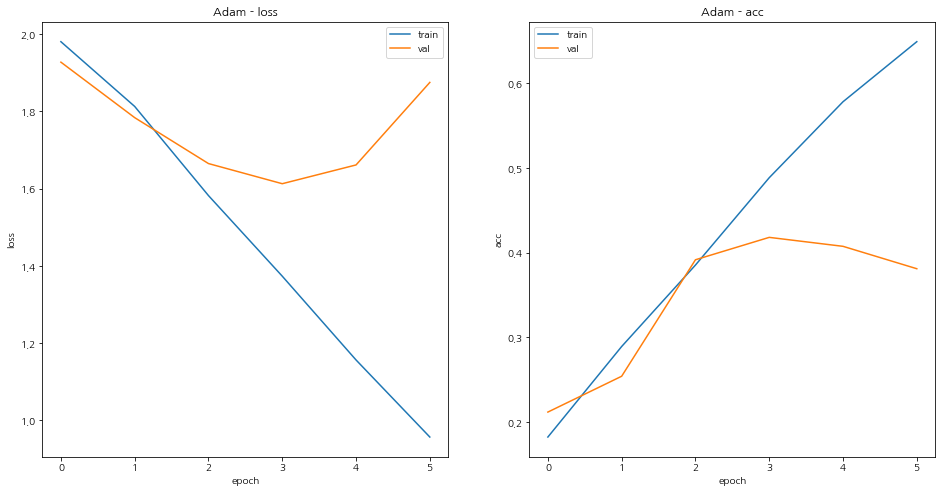

In [42]:
# adam

plt.figure(figsize = (16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.title('Adam - loss')

plt.subplot(1,2,2)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train','val'])
plt.title('Adam - acc')

plt.show()

In [43]:
op_adam = model.evaluate(val_input,val_target)

6/6 [==============================] - 0s 7ms/step - loss: 1.6128 - accuracy: 0.4180


# sgd optimizer

In [44]:
model.compile(optimizer = 'SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb=callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb=callbacks.EarlyStopping(patience=2,restore_best_weights=True)

history = model.fit(train_input, train_target, batch_size=batch_size, epochs = epochs,
                        shuffle=True, validation_data=(val_input, val_target),
                        steps_per_epoch = steps_per_epoch,
                        callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/50
59/59 [==============================] - 3s 37ms/step - loss: 1.1117 - accuracy: 0.6034 - val_loss: 1.6307 - val_accuracy: 0.4021
Epoch 2/50
59/59 [==============================] - 1s 13ms/step - loss: 1.0636 - accuracy: 0.6255 - val_loss: 1.6346 - val_accuracy: 0.4074
Epoch 3/50
59/59 [==============================] - 1s 14ms/step - loss: 1.0094 - accuracy: 0.6233 - val_loss: 1.6232 - val_accuracy: 0.4074
Epoch 4/50
59/59 [==============================] - 1s 15ms/step - loss: 1.0169 - accuracy: 0.6502 - val_loss: 1.6064 - val_accuracy: 0.3915
Epoch 5/50
59/59 [==============================] - 1s 13ms/step - loss: 0.9530 - accuracy: 0.6674 - val_loss: 1.7237 - val_accuracy: 0.4021
Epoch 6/50
59/59 [==============================] - 1s 13ms/step - loss: 1.0159 - accuracy: 0.6276 - val_loss: 1.7340 - val_accuracy: 0.3862


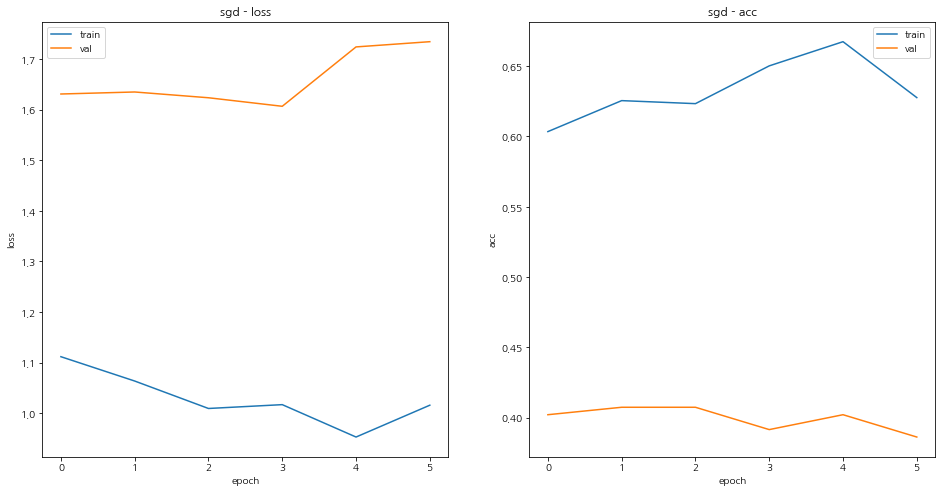

In [45]:
# sgd

plt.figure(figsize = (16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.title('sgd - loss')

plt.subplot(1,2,2)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train','val'])
plt.title('sgd - acc')

plt.show()

In [46]:
op_sgd = model.evaluate(val_input,val_target)

6/6 [==============================] - 0s 7ms/step - loss: 1.6064 - accuracy: 0.3915


# Adagrad optimizer

In [47]:
model.compile(optimizer = 'adagrad', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb=callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stopping_cb=callbacks.EarlyStopping(patience=2,restore_best_weights=True)

history = model.fit(train_input, train_target, batch_size=batch_size, epochs = epochs,
                        shuffle=True, validation_data=(val_input, val_target),
                        steps_per_epoch = steps_per_epoch,
                        callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/50
59/59 [==============================] - 3s 33ms/step - loss: 0.9730 - accuracy: 0.6529 - val_loss: 1.6714 - val_accuracy: 0.4074
Epoch 2/50
59/59 [==============================] - 1s 13ms/step - loss: 0.9405 - accuracy: 0.6539 - val_loss: 1.6843 - val_accuracy: 0.4021
Epoch 3/50
59/59 [==============================] - 1s 16ms/step - loss: 0.9319 - accuracy: 0.6797 - val_loss: 1.6703 - val_accuracy: 0.4180
Epoch 4/50
59/59 [==============================] - 1s 13ms/step - loss: 0.9401 - accuracy: 0.6647 - val_loss: 1.6878 - val_accuracy: 0.4127
Epoch 5/50
59/59 [==============================] - 1s 13ms/step - loss: 0.9076 - accuracy: 0.6926 - val_loss: 1.6951 - val_accuracy: 0.4021


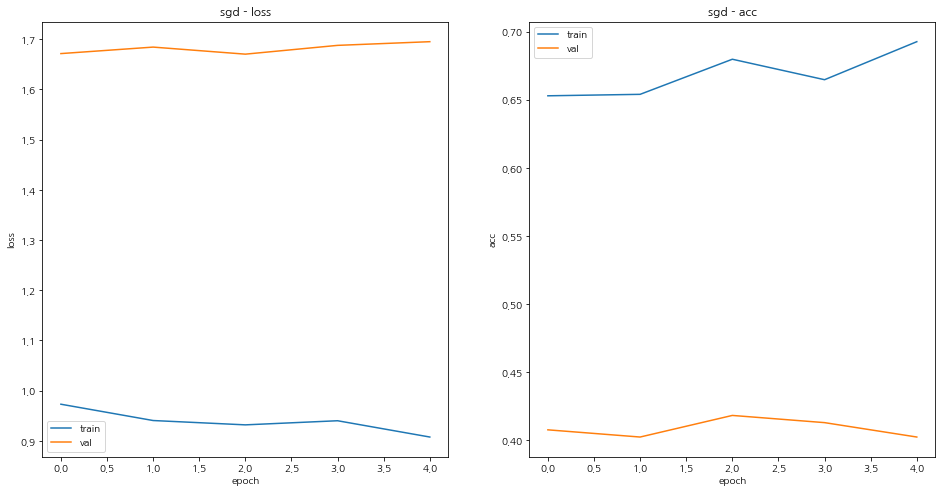

In [48]:
# adagrad

plt.figure(figsize = (16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.title('sgd - loss')

plt.subplot(1,2,2)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train','val'])
plt.title('sgd - acc')

plt.show()

In [49]:
op_adagrad = model.evaluate(val_input,val_target)

6/6 [==============================] - 0s 6ms/step - loss: 1.6703 - accuracy: 0.4180


In [56]:
pd.DataFrame([op_adam, op_sgd, op_adagrad], columns = ['loss','acc'], index = ['adam','sgd','adagrad'])

,loss,acc
adam,1.612801,0.417989
sgd,1.606384,0.391534
adagrad,1.670285,0.417989


## 테스트 데이터 사용 및 결과 확인 - adam 사용

In [17]:
X_test.shape, Y_test.shape

((210, 100, 100, 3), (210,))

In [18]:
y_pred = model.predict(X_test)

7/7 [==============================] - 0s 5ms/step


In [19]:
y_pred = np.argmax(y_pred, 1)

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

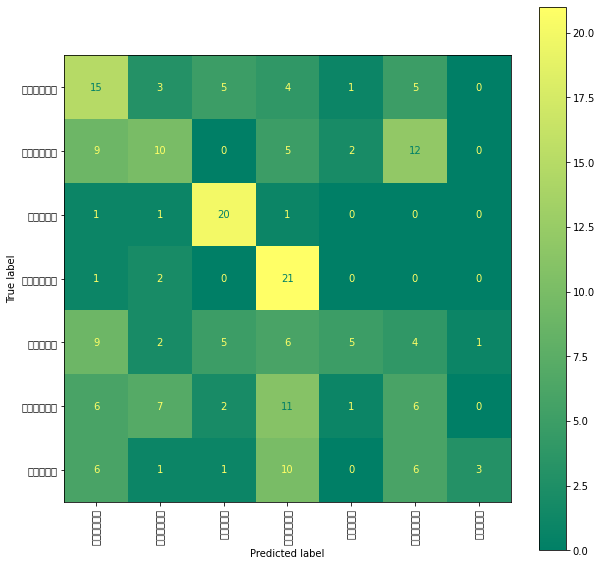

In [24]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [25]:
from sklearn.metrics import classification_report

report = classification_report(Y_test, y_pred, target_names = categories, output_dict = True)
df_report = pd.DataFrame(report).transpose()

In [26]:
df_report

,precision,recall,f1-score,support
슬픔,0.319149,0.454545,0.375000,33.000000
중립,0.384615,0.263158,0.312500,38.000000
기쁨,0.606061,0.869565,0.714286,23.000000
당황,0.362069,0.875000,0.512195,24.000000
분노,0.555556,0.156250,0.243902,32.000000
불안,0.181818,0.181818,0.181818,33.000000
상처,0.750000,0.111111,0.193548,27.000000
accuracy,0.380952,0.380952,0.380952,0.380952
macro avg,0.451324,0.415921,0.361893,210.000000
weighted avg,0.437163,0.380952,0.342866,210.000000


- 데이터의 수가 부족해서 다소 부정확한 결과 도출

# Cifar10 데이터

## 패키지 로드 및 전처리

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, Input
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers, initializers, regularizers, metrics, callbacks
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

In [30]:
cifar10 = datasets.cifar10

In [31]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 15s 0us/step


In [32]:
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [33]:
train_images = train_images/255.0
test_images = test_images/255.0

In [34]:
x = np.concatenate((train_images, test_images))
y = np.concatenate((train_labels, test_labels))

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state = 42) # train / test 분할

In [35]:
train_input, val_input, train_target, val_target = train_test_split(x_train, y_train, test_size = 0.1,
                                                                    random_state = 42) # train / val 분할

In [36]:
print(train_input.shape, train_target.shape, val_input.shape, val_target.shape)

(48600, 32, 32, 3) (48600, 1) (5400, 32, 32, 3) (5400, 1)


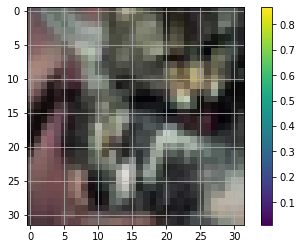

In [37]:
plt.figure()
plt.imshow(train_input[0])
plt.colorbar()
plt.grid(True)
plt.show()

In [39]:
batch_size = 32
num_classes = len(np.unique(train_target))
epochs = 50
lr = 1e-5
lr_weight_decay = 0.95

train_target = np_utils.to_categorical(train_target, num_classes) # one-hot vector로 변환
val_target = np_utils.to_categorical(val_target, num_classes)

## 최적의 dropout 탐색 및 모델 실행

In [ ]:
from keras import initializers
import copy

result = {}
y = {}
loss = []
accuracy = []

dropouts = [num/10 for num in range(8)]

for dropout in dropouts:
    print("Dropout : ", (dropout))
    model = Sequential()

    # layer 1
    model.add(Conv2D(64, 3, padding='same', activation='relu',input_shape=(train_input.shape[1:])))
    model.add(Dropout(dropout))  
    model.add(Conv2D(64, 3, activation='relu',padding='same'))
    model.add(Dropout(dropout))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # layer 2
    model.add(Conv2D(128, 3, activation='relu',padding='same'))
    model.add(Dropout(dropout))                                        
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # layer 3                         
    model.add(Conv2D(256, 3, activation='relu',padding='same'))
    model.add(Dropout(dropout)) 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # layer 4
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))

    # layer 5
    model.add(Dense(512, activation='relu'))

    # layer 6
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only = True)

    early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights = True)

    history = model.fit(train_input, train_target, batch_size=batch_size, epochs =epochs, verbose=1, 
                        shuffle=True, validation_data=(val_input, val_target),
                        callbacks = [checkpoint_cb, early_stopping_cb])
    
    score = model.evaluate(val_input, val_target, verbose=0)
    y[dropout] = model.predict(val_input)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    result[dropout] = copy.deepcopy(history.history)   
    loss.append(score[0])
    accuracy.append(score[1])

Dropout :  0.0
Epoch 1/50
1519/1519 [==============================] - 17s 5ms/step - loss: 1.3694 - accuracy: 0.4975 - val_loss: 0.9586 - val_accuracy: 0.6554
Epoch 2/50
1519/1519 [==============================] - 7s 5ms/step - loss: 0.8536 - accuracy: 0.7015 - val_loss: 0.7971 - val_accuracy: 0.7180
Epoch 3/50
1519/1519 [==============================] - 7s 5ms/step - loss: 0.6504 - accuracy: 0.7726 - val_loss: 0.7317 - val_accuracy: 0.7511
Epoch 4/50
1519/1519 [==============================] - 7s 5ms/step - loss: 0.5148 - accuracy: 0.8199 - val_loss: 0.7727 - val_accuracy: 0.7480
Epoch 5/50
169/169 [==============================] - 0s 2ms/step
Test score: 0.7316938638687134
Test accuracy: 0.7511110901832581
Dropout :  0.1
Epoch 1/50
1519/1519 [==============================] - 9s 5ms/step - loss: 1.4285 - accuracy: 0.4755 - val_loss: 1.0362 - val_accuracy: 0.6226
Epoch 2/50
1519/1519 [==============================] - 7s 5ms/step - loss: 0.9270 - accuracy: 0.6722 - val_loss: 1.00

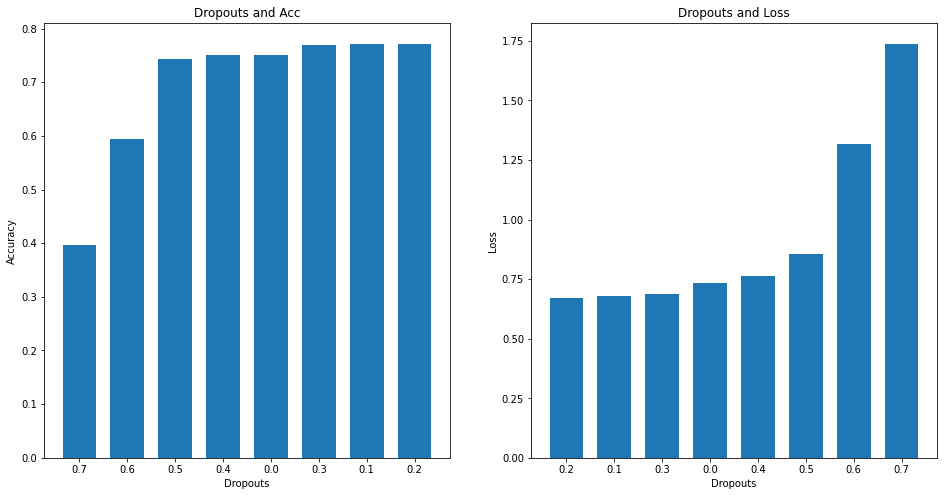

In [ ]:
x = dropouts
x = list(map(str, x))
y = accuracy
z = loss

df = pd.DataFrame(
    dict(
        Dropouts = x,
        accuracy = y,
        loss = z
    )
)

acc_sorted = df.sort_values('accuracy')
loss_sorted = df.sort_values('loss')

plt.figure(figsize = (16,8))

plt.subplot(1,2,1)
plt.bar('Dropouts','accuracy', data = acc_sorted, width = 0.7)
plt.xlabel('Dropouts')
plt.ylabel('Accuracy')
plt.title('Dropouts and Acc')

plt.subplot(1,2,2)
plt.bar('Dropouts', 'loss', data = loss_sorted, width = 0.7)
plt.xlabel('Dropouts')
plt.ylabel('Loss')
plt.title('Dropouts and Loss')

plt.show()

- accuracy와 loss를 모두 고려했을 때 dropout 0.2으로 모델 제작

## 평가 지표 향상을 위한 모델 변형

In [42]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_12 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 64)       

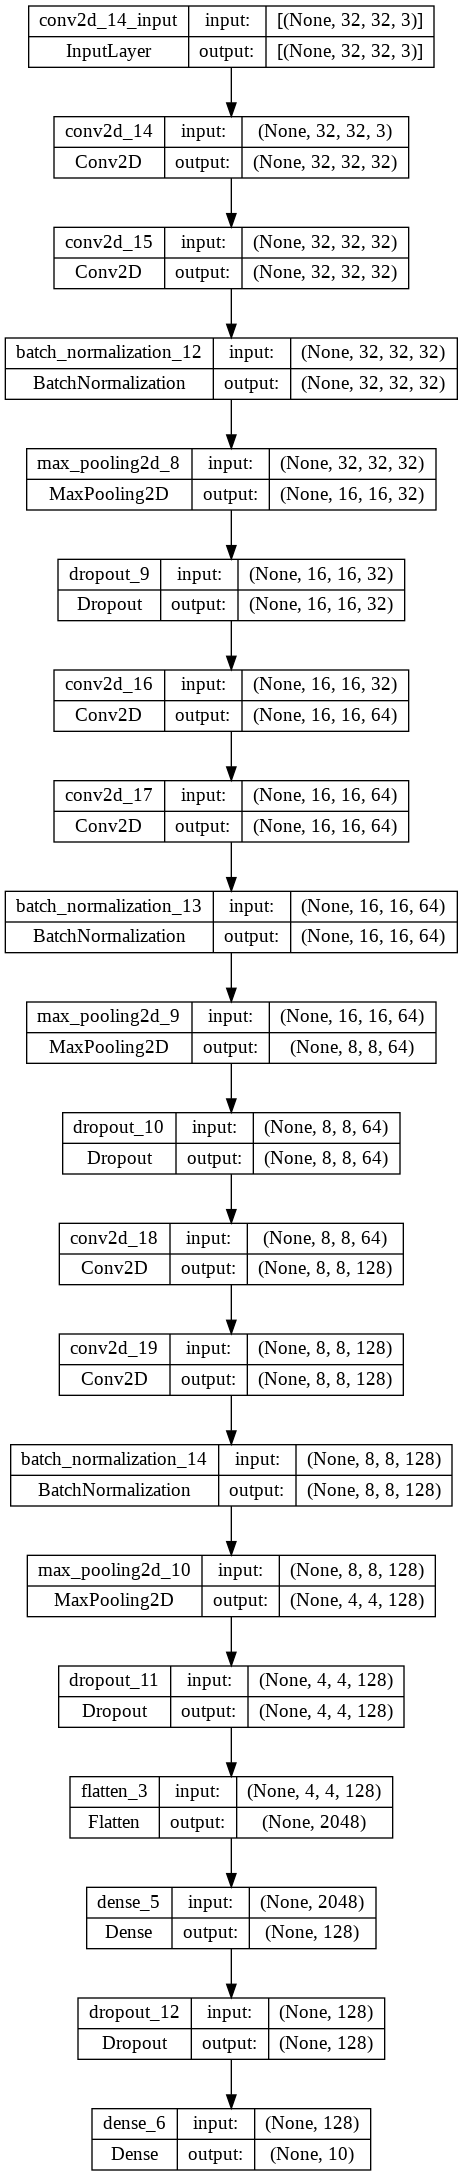

In [44]:
keras.utils.plot_model(model, show_shapes= True)

In [45]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1,
                                    horizontal_flip = True)

train_generator = data_generator.flow(train_input, train_target, batch_size)
steps_per_epoch = train_input.shape[0] // batch_size

In [46]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only = True)

early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,restore_best_weights = True)

history = model.fit(train_input, train_target, batch_size=batch_size, epochs = epochs,
                        shuffle=True, validation_data=(val_input, val_target),
                        steps_per_epoch = steps_per_epoch,
                        callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/50
1518/1518 [==============================] - 16s 10ms/step - loss: 1.5474 - accuracy: 0.4417 - val_loss: 1.1972 - val_accuracy: 0.5731
Epoch 2/50
1518/1518 [==============================] - 13s 8ms/step - loss: 1.0723 - accuracy: 0.6235 - val_loss: 0.9630 - val_accuracy: 0.6628
Epoch 3/50
1518/1518 [==============================] - 10s 6ms/step - loss: 0.9053 - accuracy: 0.6833 - val_loss: 0.9018 - val_accuracy: 0.6915
Epoch 4/50
1518/1518 [==============================] - 11s 7ms/step - loss: 0.7992 - accuracy: 0.7255 - val_loss: 0.7455 - val_accuracy: 0.7415
Epoch 5/50
1518/1518 [==============================] - 9s 6ms/step - loss: 0.7184 - accuracy: 0.7528 - val_loss: 0.7582 - val_accuracy: 0.7454
Epoch 6/50
1518/1518 [==============================] - 11s 7ms/step - loss: 0.6525 - accuracy: 0.7754 - val_loss: 0.6984 - val_accuracy: 0.7648
Epoch 7/50
1518/1518 [==============================] - 10s 6ms/step - loss: 0.6051 - accuracy: 0.7915 - val_loss: 0.7535 - val_ac

## 결과 확인

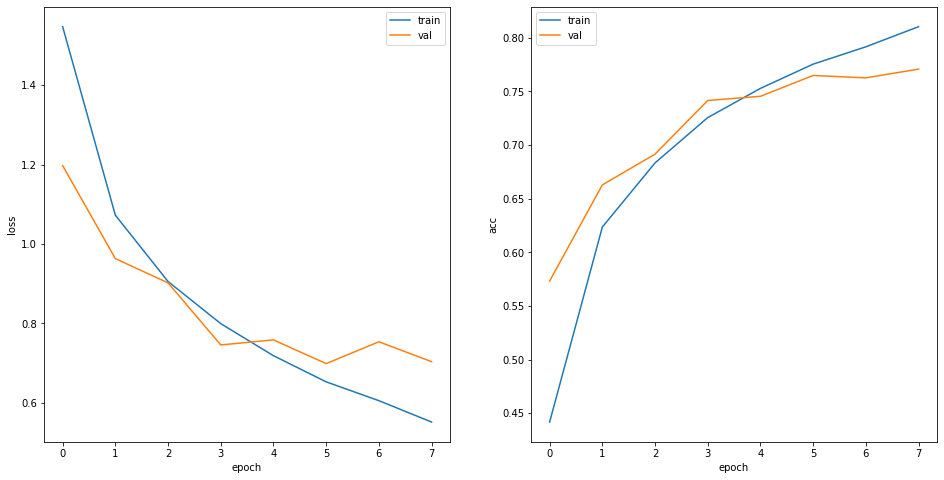

In [48]:
plt.figure(figsize = (16,8))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])

plt.subplot(1,2,2)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['train','val'])

plt.show()

In [49]:
model.evaluate(val_input, val_target)

169/169 [==============================] - 1s 4ms/step - loss: 0.6984 - accuracy: 0.7648


[0.698420524597168, 0.7648147940635681]

## 테스트 데이터 사용

In [50]:
x_test.shape, y_test.shape

((6000, 32, 32, 3), (6000, 1))

In [51]:
y_pred = model.predict(x_test)

188/188 [==============================] - 1s 3ms/step


In [52]:
y_pred = np.argmax(y_pred,1)

In [53]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test, y_pred)

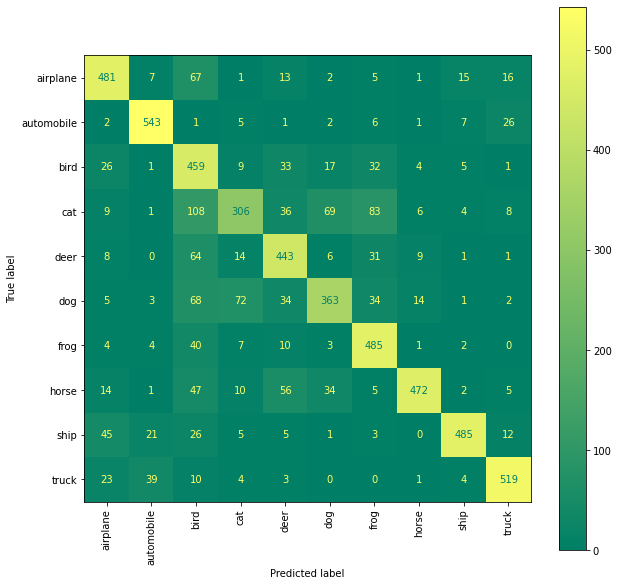

In [54]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [55]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names = labels, output_dict = True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
airplane,0.779579,0.791118,0.785306,608.000000
automobile,0.875806,0.914141,0.894563,594.000000
bird,0.515730,0.781942,0.621530,587.000000
cat,0.706697,0.485714,0.575729,630.000000
deer,0.698738,0.767764,0.731627,577.000000
dog,0.730382,0.609060,0.664227,596.000000
frog,0.709064,0.872302,0.782258,556.000000
horse,0.927308,0.730650,0.817316,646.000000
ship,0.922053,0.804312,0.859167,603.000000
truck,0.879661,0.860697,0.870075,603.000000


# cifar10 데이터 로드 및 정규화

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


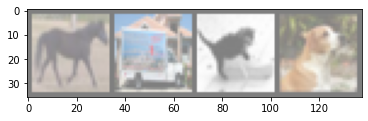

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

# 모델 정의

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, len(classes))
    
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = Model()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 1e-4)

In [13]:
for epoch in range(5):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.419
[1,  4000] loss: 1.422
[1,  6000] loss: 1.408
[1,  8000] loss: 1.399
[1, 10000] loss: 1.381
[1, 12000] loss: 1.386
[2,  2000] loss: 1.347
[2,  4000] loss: 1.378
[2,  6000] loss: 1.355
[2,  8000] loss: 1.370
[2, 10000] loss: 1.344
[2, 12000] loss: 1.342
[3,  2000] loss: 1.332
[3,  4000] loss: 1.322
[3,  6000] loss: 1.318
[3,  8000] loss: 1.307
[3, 10000] loss: 1.318
[3, 12000] loss: 1.314
[4,  2000] loss: 1.286
[4,  4000] loss: 1.286
[4,  6000] loss: 1.260
[4,  8000] loss: 1.286
[4, 10000] loss: 1.267
[4, 12000] loss: 1.293
[5,  2000] loss: 1.263
[5,  4000] loss: 1.258
[5,  6000] loss: 1.247
[5,  8000] loss: 1.243
[5, 10000] loss: 1.265
[5, 12000] loss: 1.225
Finished Training


# test data

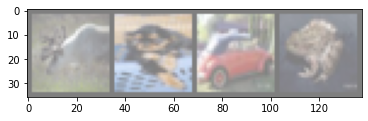

In [9]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [10]:
correct = 0
total = 0

with torch.no_grad(): # 출력에 대한 변화도 계산 X
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산
        outputs = model(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 43 %


In [11]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 45.4 %
Accuracy for class: car   is 62.6 %
Accuracy for class: bird  is 20.5 %
Accuracy for class: cat   is 15.3 %
Accuracy for class: deer  is 40.2 %
Accuracy for class: dog   is 32.9 %
Accuracy for class: frog  is 64.6 %
Accuracy for class: horse is 51.9 %
Accuracy for class: ship  is 54.3 %
Accuracy for class: truck is 49.8 %
